In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore

start = 0
goal = 10
actual = 0
moment_of_inertia = 10
max_torque = 50
time_frame = 30
dt = 0.1

class NewPID:
    def __init__(self, intertia, dt=0.1, max_torque = 5, momentum=0.2, overshoot_threshold=0.5, ideal_convergence_time = 5):
        self.intertia = intertia
        self.kp = 0.01
        self.ki = 0.01
        self.kd = 0.01
        self.integral = 0.0
        self.prev_error = 0.0
        self.actual_velocity = 0.0
        self.dt = dt
        self.max_torque = max_torque
        self.momentum = momentum
        self.overshoot_threshold = overshoot_threshold
        self.ideal_convergence_time = ideal_convergence_time
    
    def newton_second_law(self, torque):
        """ Computes acceleration based on Newton's second law of motion. """
        output = min(self.max_torque, torque) / self.intertia
        return output

    def simulate_motion(self, rqst_velocity, params : dict = None):
        """ Simulates motion based on the torque input and updates the rqst_velocity. """
        if params is None:
            params = {"kp": self.kp, "ki": self.ki, "kd": self.kd}

        acceleration = self.newton_second_law(self.compute_value_based_on_pid(rqst_velocity, params = params))
        self.actual_velocity += acceleration * self.dt
        return self.actual_velocity
    
    def moving_average(self, data, window_size=5):
        padded_data = np.pad(data, (window_size//2, window_size-1-window_size//2), mode='edge')
        return np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')

    def compute_value_based_on_pid(self, rqst_velocity, update_values=True, params : dict = None):
        """ 
        Computes the PID value based on the error and the PID constants.
        For our purposes, this outputs the torque value 
        """
        if params is None:
            params = {"kp": self.kp, "ki": self.ki, "kd": self.kd}
        
        error = rqst_velocity - self.actual_velocity
        derivative = (error - self.prev_error) / self.dt if self.dt > 0 else 0

        if update_values:
            self.integral += error
            self.prev_error = error
        output = params.get("kp") * error + params.get("ki") * self.integral + params.get("kd") * derivative

        if output > self.max_torque:
            output = self.max_torque
            
        return output
    
    def compute_error_grad(self, goal, max_time=100, params : dict = None):

        """"
        Params is the dictionary of PID values to be used for the simulation.
        """

        self.reset()

        total_error = 0
        max_velocity = 0
        data = []
        oscillations = 0
        convergence_time = 0

        time = np.arange(0, max_time, self.dt)
        for t_time in time:
            velocity = self.simulate_motion(goal, params)
            total_error += abs(goal - velocity)
            max_velocity = max(max_velocity, velocity)  # Track the max velocity
            data.append(velocity)

            # Track the oscillations that have an exceedingly high amplitude
            if len(data) > 1 and data[-1] < data[-2] and data[-2] > goal and abs(data[-2] - goal) > 0.5:
                oscillations += 1
            


        convergence_time = self.compute_convergence_time(goal, max_time, params)[0]

        # Penailty is relative to how far the max velocity is from the goal
        penality = abs(max_velocity - goal) 

        # Apply a penalty for oscillations
        penality += oscillations 

        # Decrease the penalty if the system converges quickly
        convergence_error = abs(convergence_time - self.ideal_convergence_time)
        penality += convergence_error

        # Check for overshoot and increase error if necessary
        total_error += penality

        total_error = (total_error / len(time)) # Normalize the error

        # print(f"{Fore.CYAN}Simulation complete for params: {params} with error: {total_error:.2f} and max velocity: {max_velocity:.2f}{Fore.RESET} and oscillations: {oscillations} and convergence time: {convergence_time:.2f}")

        return total_error, (max_velocity - goal), data
    
    def auto_tune_gradient_descent(self, goal, max_iter=500, tolerance=1e-3, learning_rate = 10, auto_accept=True, max_time = 100):
        best_kp, best_ki, best_kd, best_overshoot = self.kp, self.ki, self.kd, float('inf')
        params = {"kp": 0, "ki": 0, "kd": 0}
        velocities = {"kp": 0, "ki": 0, "kd": 0}  # Velocity for momentum

        best_error, _, _ = self.compute_error_grad(goal, max_time, params)

        for _ in range(max_iter):
            base_error, _, _ = self.compute_error_grad(goal, max_time, params)
            improved = False

            gradients = {}

            for param in params.keys():
                original_value = params[param]
                params[param] += learning_rate
                new_error, _, _ = self.compute_error_grad(goal, max_time, params)
                grad = (new_error - base_error) / learning_rate
                velocities[param] = self.momentum * velocities[param] - learning_rate * grad
                params[param] = max(0, original_value + velocities[param])  # Ensure non-negative values
                gradients[param] = grad

            current_error, overshoot, output_data = self.compute_error_grad(goal, max_time, params)

            # compute convergence time
            convergence_time = self.compute_convergence_time(goal, max_time, params)[0]

            if current_error < best_error - tolerance and overshoot < self.overshoot_threshold:
                best_kp, best_ki, best_kd, best_overshoot = params["kp"], params["ki"], params["kd"], overshoot
                best_error = current_error
                improved = True

            if not improved:
                learning_rate *= 0.98  # Reduce learning rate if no improvement

                # Since we haven't improved in a while, add a little randomness to the PID values
                params["kp"] = np.random.uniform(0, params["kp"] + params["kp"] * 0.5)
                params["ki"] = np.random.uniform(0, params["ki"] + params["ki"] * 0.5 )
                params["kd"] = np.random.uniform(0, params["kd"] + params["kd"] * 0.5)

        if auto_accept:
            self.kp, self.ki, self.kd = best_kp, best_ki, best_kd

        # if (len(best_data) == 0):
        #     print(f"Auto-tuning failed: No improvements made. Best PID: Kp={best_kp}, Ki={best_ki}, Kd={best_kd} Error={best_error}")
        #     raise Exception("Auto-tuning failed.")

        print(f"Final Tuned PID, Gradient Method: Kp={best_kp}, Ki={best_ki}, Kd={best_kd}, Error={best_error}, Overshoot={best_overshoot}")

        return {"kp": best_kp, "ki": best_ki, "kd": best_kd}
    
    def auto_tune_range(self, goal, max_time=10, auto_accept=True):
        """Auto-tunes PID by testing a range of P, I, and D values and selecting the best based on total error and overshoot."""
        best_kp, best_ki, best_kd, best_overshoot, best_data = self.kp, self.ki, self.kd, float('inf'), []
        min_error = float('inf')
        max_overshoot = 0.5
        
        kp_range = np.linspace(0.01, 200, 30)  # Adjust range as needed
        ki_range = np.linspace(0.01, 200, 30)
        kd_range = np.linspace(0.01, 200, 30)
        
        for kp in kp_range:
            for ki in ki_range:
                for kd in kd_range:
                    self.kp, self.ki, self.kd = kp, ki, kd
                    overshoot_value = float('inf')
                    total_error = 0
                    
                    velocity_data = []
                    time = np.arange(0, max_time, self.dt)
                    
                    for t in time:
                        velocity = self.simulate_motion(goal)
                        velocity_data.append(velocity)
                        total_error += abs(goal - velocity)

                    # Smooth out the data using a moving average
                    smoothed_data = self.moving_average(velocity_data, window_size=5)

                    # Find the first peak to calculate overshoot
                    first_value = smoothed_data[0]
                    for i in range(1, len(smoothed_data) - 1):
                        if len(smoothed_data) > 1 and smoothed_data[i] < first_value and first_value > goal:
                            overshoot_value = abs((first_value - goal))
                        first_value = smoothed_data[i]

                    
                    if (overshoot_value < max_overshoot and total_error < min_error):
                        min_error = total_error
                        best_kp, best_ki, best_kd, best_overshoot, best_data = kp, ki, kd, overshoot_value, smoothed_data
                    
                    self.reset()
        
        print(f"Tuned PID values: Kp={best_kp}, Ki={best_ki}, Kd={best_kd}, Min Error={min_error}, Overshoot={best_overshoot}")
        
        if auto_accept:
            self.kp, self.ki, self.kd = best_kp, best_ki, best_kd

        return best_data
    
    def compute_convergence_time(self, goal, max_time=100, params : dict = None):
        """Computes the time taken for the system to converge to the goal."""
        self.reset()
        time = 0
        data = []
        while time < max_time:
            velocity = self.simulate_motion(goal, params)
            data.append(velocity)
            if abs(velocity - goal) < 0.1:
                break
            time += self.dt
        self.reset()
        return time, data
    
    def auto_tune_zieger(self, goal, max_time=50, auto_accept = True):
        """Auto-tunes PID using Ziegler-Nichols method."""
        temp_kp = self.kp
        temp_ki = self.ki
        temp_kd = self.kd

        prev_velocity = 0
        oscillations = []
        amplitudes = []

        Ku = None # unlimited gain
        Tu = None

        # Ramp up Kp until stable oscillations occur
        while temp_kp < 200:  
            self.actual_velocity = 0
            velocity_data = []
            time = np.arange(0, max_time, self.dt)
            
            for t in time:
                velocity = self.simulate_motion(goal)
                velocity_data.append(velocity)

                # Detect zero crossings for oscillation period
                if prev_velocity < goal and velocity >= goal:
                    if len(oscillations) > 1:
                        Tu = t - oscillations[-1] # Oscillation period
                    oscillations.append(t)
                    amplitudes.append((velocity - goal))

                prev_velocity = velocity
            
            # Check if oscillations have formed
            if len(oscillations) > 20 and Tu is not None:
                print(f"Stable oscillations detected: Kp={temp_kp}, Tu={Tu}, Aplitudes={(amplitudes)}")
                # Compute the amplitude ratio
                amp_ratio = amplitudes[0] / amplitudes[1]
                print(f"Amplitude ratio: {amp_ratio}")
                Ku = 1/amp_ratio  # Ultimate gain
                break

            temp_kp += 0.1  # Increment Kp to find Ku

        if Ku is None or Tu is None:
            print("Auto-tuning failed: No stable oscillations detected.")
            return
        
        # Apply Ziegler-Nichols tuning rules (Classic PID)
        temp_kp = 0.2 * Ku
        temp_ki = 0.4 * Ku / Tu
        temp_kd = 0.0666 * Ku * Tu

        print(f"Tuned PID values: Kp={temp_kp}, Ki={temp_ki}, Kd={temp_kd}")

        if auto_accept:
            self.kp = temp_kp
            self.ki = temp_ki
            self.kd = temp_kd

    def run_simulation(self, goal, max_time=100, params : dict = None):
        """Runs a simulation of the PID controller."""
        self.reset()
        data = []
        time = np.arange(0, max_time, self.dt)
        for t in time:
            velocity = self.simulate_motion(goal, params)
            data.append(velocity)
        self.reset()
        return data

    def reset(self):
        """Resets the PID controller."""
        self.integral = 0.0
        self.prev_error = 0.0
        self.actual_velocity = 0.0


Final Tuned PID, Gradient Method: Kp=15.178452047643056, Ki=0, Kd=0, Error=0.36954953778297894, Overshoot=-5.329070518200751e-15
Convergence time: 3.40


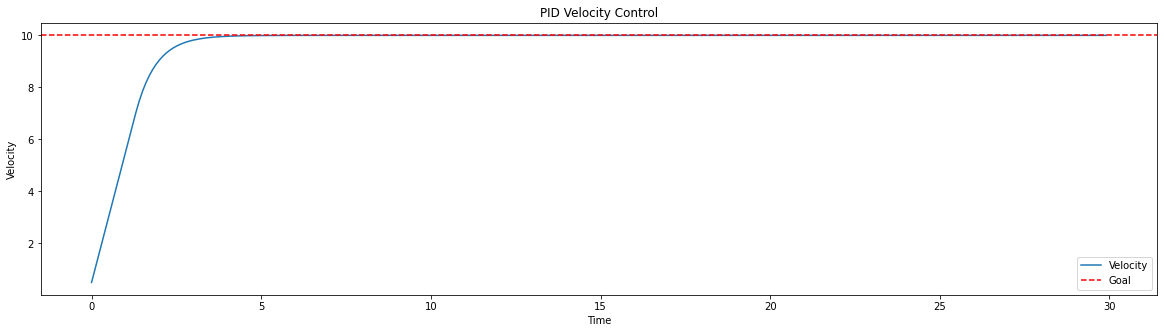

In [13]:
pid = NewPID(intertia = moment_of_inertia, max_torque=max_torque, overshoot_threshold = 0.5, ideal_convergence_time = 10)
pid.reset()
params = pid.auto_tune_gradient_descent(goal, max_iter=5000, max_time = time_frame, learning_rate=200, auto_accept=True, tolerance = 0.001)
pid.reset()
time = np.arange(0, time_frame, dt)
data = []

# Try and run the simulation
for _ in time:
    actual = pid.simulate_motion(goal)
    data.append(actual)

convergence_time = pid.compute_convergence_time(goal, time_frame, params)
print(f"{Fore.GREEN}Convergence time: {convergence_time[0]:.2f}")

# Create a Graph
plt.figure(figsize=(20, 5))
plt.plot(time, data, label="Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("PID Velocity Control")
plt.legend()
plt.show()

Stable oscillations detected: Kp=2.0100000000000007, Tu=0.9000000000000004, Aplitudes=[0.08381279790999763, 0.08000070994465247, 0.020082619646009547, 0.044548726677398065, 0.05492371394277917, 0.010942119776192527, 0.08795112321957532, 0.07909389638476583, 0.020258001900362643, 0.04885505214934582, 0.049932895355604856, 0.02019031974861818, 0.07806303397107683, 0.09290351409430109, 0.005697337451133322, 0.06711393437145396, 0.03096954174580624, 0.04266685578186191, 0.05492617737788841, 0.019492393150462917, 0.0776357275269568]
Amplitude ratio: 1.0476506767000255
Tuned PID values: Kp=0.19090332727123904, Ki=0.42422961615830884, Kd=0.057213727183190365


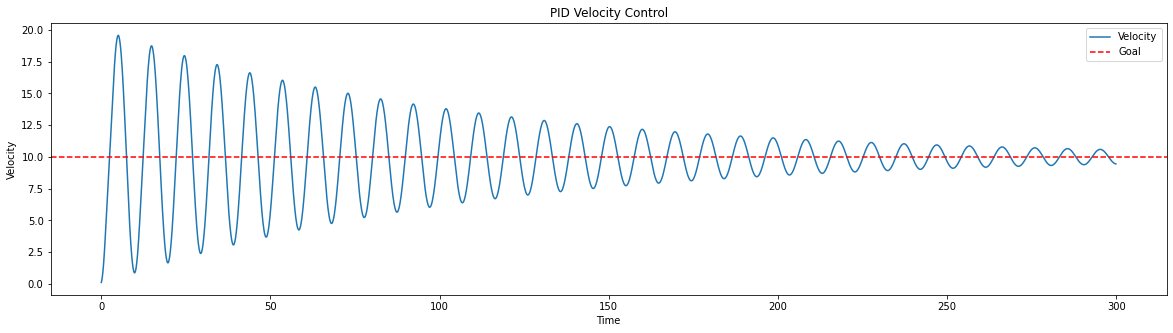

In [11]:
pid = NewPID(intertia=moment_of_inertia, max_torque=max_torque)
pid.reset()
pid.auto_tune_zieger(goal, max_time = time_frame)
pid.reset()
time = np.arange(0, 300, dt)
data = []

# Try and run the simulation
for _ in time:
    actual = pid.simulate_motion(goal)
    data.append(actual)

# Create a Graph
plt.figure(figsize=(20, 5))
plt.plot(time, data, label="Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("PID Velocity Control")
plt.legend()
plt.show()

Tuned PID values: Kp=193.10379310344828, Ki=0.01, Kd=0.01, Min Error=96.51383979049882, Overshoot=0.0053597941191796394
Convergence time: 1.90


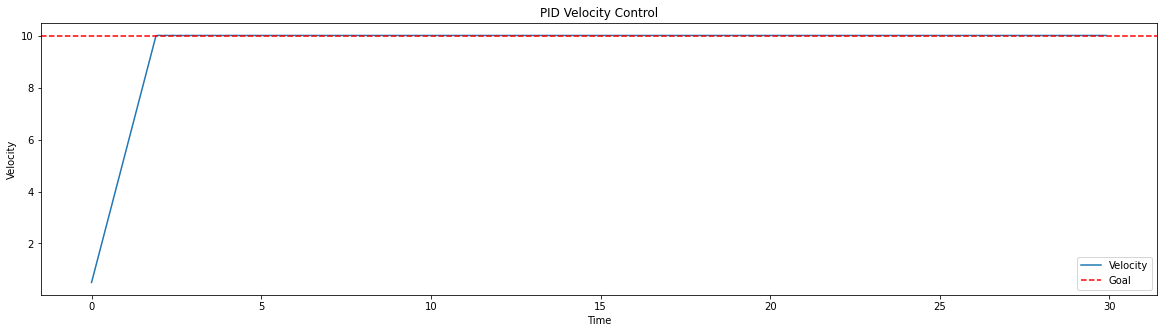

In [12]:
pid = NewPID(intertia=moment_of_inertia, max_torque=max_torque)
pid.reset()
data2 = pid.auto_tune_range(goal, max_time=time_frame)
pid.reset()
time = np.arange(0, time_frame, dt)
data = []

# Print the convergence time 
convergence_time = pid.compute_convergence_time(goal, time_frame)
print(f"{Fore.GREEN}Convergence time: {convergence_time[0]:.2f}")

# Try and run the simulation
for _ in time:
    actual = pid.simulate_motion(goal)
    data.append(actual)

# Create a Graph
plt.figure(figsize=(20, 5))
plt.plot(time, data, label="Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("PID Velocity Control")
plt.legend()
plt.show()


Convergence time: 1.90


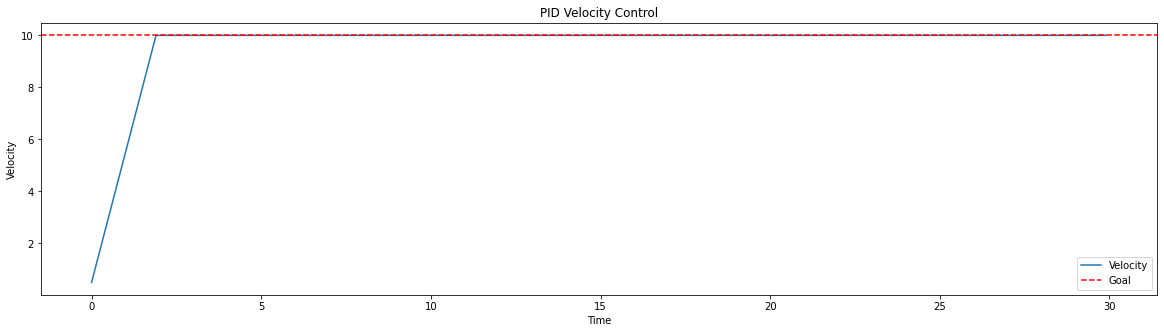

In [32]:
pid = NewPID(intertia=moment_of_inertia, max_torque=max_torque)
params = {"kp": 183, "ki": 0, "kd": 0.00}
data = pid.run_simulation(goal, max_time=time_frame, params = params)
convergence_time = pid.compute_convergence_time(goal, time_frame, params= params)
print(f"{Fore.GREEN}Convergence time: {convergence_time[0]:.2f}")
# Graph the data
plt.figure(figsize=(20, 5))
plt.plot(time, data, label="Velocity")
plt.axhline(y=goal, color='r', linestyle='--', label="Goal")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("PID Velocity Control")

plt.legend()
plt.show()